# Construct the hybrid graph representation of a 2D cartesian map

In [63]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.tunnels import detect_tunnels,get_entry_exit

from panav.util import unique_tx

import shapely
import numpy as np
from matplotlib import pyplot as plt

from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely import Polygon,LineString,Point


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: detect tunnels in the environment

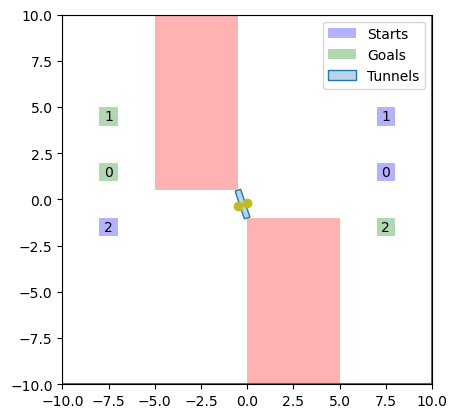

In [64]:
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])


start_locs = np.array([[5,1],[5,3],[-5,-1]])*1.5

goal_locs = np.array([[-5,1],[-5,3],[5,-1]])*1.5



starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-5.0,-0.5),(0.5,10))

O2 = Box2DRegion((-0.0,5.0),(-10,-1.0))


# O1 = Box2DRegion((-2.5,2.5),(0.5,10))
# O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

ax = plt.gca()

draw_env(env,ax=ax)
        

labeled = False
env.tunnels = detect_tunnels(env,bloating_r)
for tunnel in env.tunnels:
    plot_polygon(tunnel.region,ax=ax,label='Tunnels' if not labeled else None,add_points =False)
    ent_pts = np.array(tunnel.end_points)
    plt.scatter(ent_pts[:,0],ent_pts[:,1])

    labeled=True
    
ax.legend()
plt.show()

## Step 2: assign locations to nodes in the hybrid graph

In [83]:
import networkx as nx
G = nx.DiGraph()
nx.set_node_attributes(G,(0,0),'loc') # Every node has a location attribute: loc \in R^d.
nx.set_node_attributes(G,'','type') # Every node has a type attribute: type \in {'start','goal','tunnel'}. Tunnel endpoints are of type 'tunnel'
nx.set_edge_attributes(G,'','type') # Every edge has a hardness attribute: type \in {'soft','hard'}.

for i,tunnel in enumerate(env.tunnels): # Add hard edges + tunnel nodes
    u = 2*i
    v = 2*i+1
    
    G.add_node(u,type='tunnel',loc = tunnel.end_points[0])
    G.add_node(v,type='tunnel',loc = tunnel.end_points[1])

    G.add_edge(u,v,type='hard')
    G.add_edge(v,u,type='hard')
    
from itertools import product

# Add start nodes
start_nodes = np.arange(G.number_of_nodes(),
                    G.number_of_nodes()+len(start_locs))
G.add_nodes_from(start_nodes, type = 'start')
nx.set_node_attributes(G,{n:{'loc':loc} for n,loc in zip(start_nodes,start_locs)})

# Add goal nodes
goal_nodes = np.arange(G.number_of_nodes(),
                    G.number_of_nodes()+len(goal_locs))
G.add_nodes_from(goal_nodes, type = 'goal')
nx.set_node_attributes(G,{n:{'loc':loc} for n,loc in zip(goal_nodes,goal_locs)})


In [84]:
# Path planning parameters
bloating_r = 0.5
d = 2
K = 3
t0 = 0
vmax = 1.0
interp_dt = 0.1

from panav.SAMP import Tube_Planning
G_soft = nx.Graph() # The graph we use to store soft edges and determine how nodes are grouped by open spaces.
# Add soft edges
for u,v in product(G.nodes,G.nodes):
    if u!=v and not (u,v) in G.edges and not G.nodes[u]['type'] == G.nodes[v]['type'] :
        # Determine if the shortest path between u, v passes through any tunnels.
        
        # Plan the shortest path
        start_region = box_2d_center(G.nodes[u]['loc'],1e-8) # Create a arbitrarily small region so that the start is very much the same as u's location.
        goal_region = box_2d_center(G.nodes[v]['loc'],1e-8)
        
        path = Tube_Planning(env,
                             start = start_region,goal = goal_region,
                             vmax = vmax,bloating_r=bloating_r,
                             obs_trajectories=[], 
                             d = d, K = K)
        if path is None:
            print("Path not find. Consider increasing the K value")
        else:
            _,x = unique_tx(*path)
            
            # print(G.nodes[u]['loc'],G.nodes[v]['loc'],x)


        # See if the path passes through any tunnels
        through_some_tunnel = False
        for tunnel_id, tunnel in enumerate(tunnels):
            ent, ex = get_entry_exit(tunnel,x)

            if not(ent is None and ex is None):
                # print(u,v,"Pass through tunnel", tunnel_id)

                through_some_tunnel = True
                break

        if not through_some_tunnel: # u-v does not pass through any tunnel.
            # print(u,v,'Does not pass through any tunnel')
            G_soft.add_edge(u,v,type='soft')
            

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


0 4 Does not pass through any tunnel
0 5 Does not pass through any tunnel
0 6 Does not pass through any tunnel
1 2 Does not pass through any tunnel
1 3 Does not pass through any tunnel
1 7 Does not pass through any tunnel
2 1 Does not pass through any tunnel
2 7 Does not pass through any tunnel
3 1 Does not pass through any tunnel
3 7 Does not pass through any tunnel
4 0 Does not pass through any tunnel
4 5 Does not pass through any tunnel
4 6 Does not pass through any tunnel
5 0 Does not pass through any tunnel
5 4 Does not pass through any tunnel
6 0 Does not pass through any tunnel
6 4 Does not pass through any tunnel
7 1 Does not pass through any tunnel
7 2 Does not pass through any tunnel
7 3 Does not pass through any tunnel


In [85]:
env.open_spaces = [c for c in nx.connected_components(G_soft)]

In [86]:
# Give all nodes in the graph an open space id
for id, c in enumerate(env.open_spaces):
    for s in c:
        G.nodes[s]['open_space_id'] = id

G_soft = nx.to_directed(G_soft)
# Add soft edges to G
G.add_edges_from(G_soft.edges(data=True))        

# Store G in the hybrid_graph variable.
env.hybrid_graph = G

In [87]:
G.edges(data=True)

OutEdgeDataView([(0, 1, {'type': 'hard'}), (0, 4, {'type': 'soft'}), (0, 5, {'type': 'soft'}), (0, 6, {'type': 'soft'}), (1, 0, {'type': 'hard'}), (1, 2, {'type': 'soft'}), (1, 3, {'type': 'soft'}), (1, 7, {'type': 'soft'}), (2, 1, {'type': 'soft'}), (2, 7, {'type': 'soft'}), (3, 1, {'type': 'soft'}), (3, 7, {'type': 'soft'}), (4, 0, {'type': 'soft'}), (4, 5, {'type': 'soft'}), (4, 6, {'type': 'soft'}), (5, 0, {'type': 'soft'}), (5, 4, {'type': 'soft'}), (6, 0, {'type': 'soft'}), (6, 4, {'type': 'soft'}), (7, 1, {'type': 'soft'}), (7, 2, {'type': 'soft'}), (7, 3, {'type': 'soft'})])